In [1]:
!pip uninstall -y tensorflow
!pip install tensorflow==1.15.2

Found existing installation: tensorflow 2.1.0
Uninstalling tensorflow-2.1.0:
  Successfully uninstalled tensorflow-2.1.0
     |████████████████████████████████| 110.5 MB 53.5 MB/s 
     |████████████████████████████████| 503 kB 48.1 MB/s 
     |████████████████████████████████| 3.8 MB 30.2 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.1.0
    Uninstalling tensorflow-estimator-2.1.0:
      Successfully uninstalled tensorflow-estimator-2.1.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.1.0
    Uninstalling tensorboard-2.1.0:
      Successfully uninstalled tensorboard-2.1.0


Importing libraries

In [2]:
import numpy as np
import pydicom
import os
import matplotlib.pyplot as plt
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *
init_notebook_mode(connected=True) 

setting the image height and width of the images

In [3]:
IMG_WIDTH = 128
IMG_HEIGHT = 128

displaying one image to get an idea

<PIL.TiffImagePlugin.TiffImageFile image mode=F size=512x512 at 0x7FC78D6C9588>


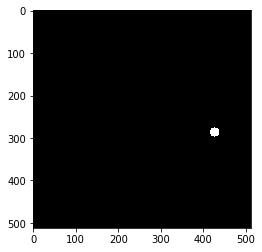

In [4]:
from PIL import Image
from matplotlib.pyplot import imshow
import cv2 
%matplotlib inline

basepath = '/kaggle/input/'
path = basepath + 'endimension-technology-test/sample_dataset_for_testing/fullsampledata/subset2mask/1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059/88_mask.tiff'
im = Image.open(path)
print(im)
imshow(im, cmap = "gray")

this function loads all scans of a patient and stacks the layers

In [5]:
def load_scan(path):
    alltiff = os.listdir(path)
#     print(alltiff)
    slides = [int(slide[:-5]) for slide in alltiff if not slide.endswith('_mask.tiff')]
    masks = [int(mask[:-10]) for mask in alltiff if mask.endswith('_mask.tiff')]
    slides.sort()
    threed = []
    threedmasks = []
    for slide in slides:
        threed.append(np.asarray(Image.open(path + str(slide) + '.tiff').resize((IMG_WIDTH, IMG_HEIGHT))))
        if slide in masks:
            threedmasks.append(np.asarray(Image.open(path + str(slide) + '_mask.tiff').resize((IMG_WIDTH, IMG_HEIGHT))))
        else:
            threedmasks.append(np.zeros([IMG_WIDTH,IMG_HEIGHT]))
    return (np.stack(threed), np.stack(threedmasks))

testing the load scan function

In [6]:
path = basepath + 'endimension-technology-test/sample_dataset_for_testing/fullsampledata/subset2mask/1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059/'
slides, masks = load_scan(path)
print(slides.shape)
print(masks.shape)


(201, 128, 128)
(201, 128, 128)


In [7]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

function to print all slides of the stack

In [8]:
def visualize(arr, rows = 21):
    f, plots = plt.subplots(rows, 10, sharex='all', sharey='all', figsize=(10, 21))
    for i in range(len(arr)):
        plots[i // 10, i % 10].axis('off')
        plots[i // 10, i % 10].imshow(arr[i], cmap='gray')

Testing the visualize function


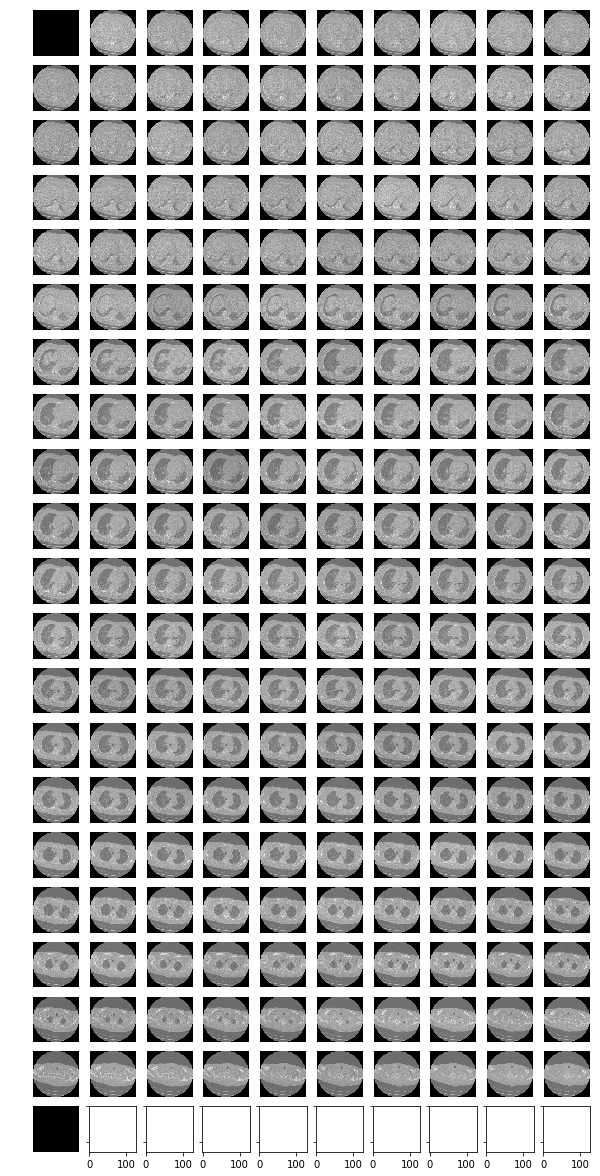

In [9]:
visualize(slides)

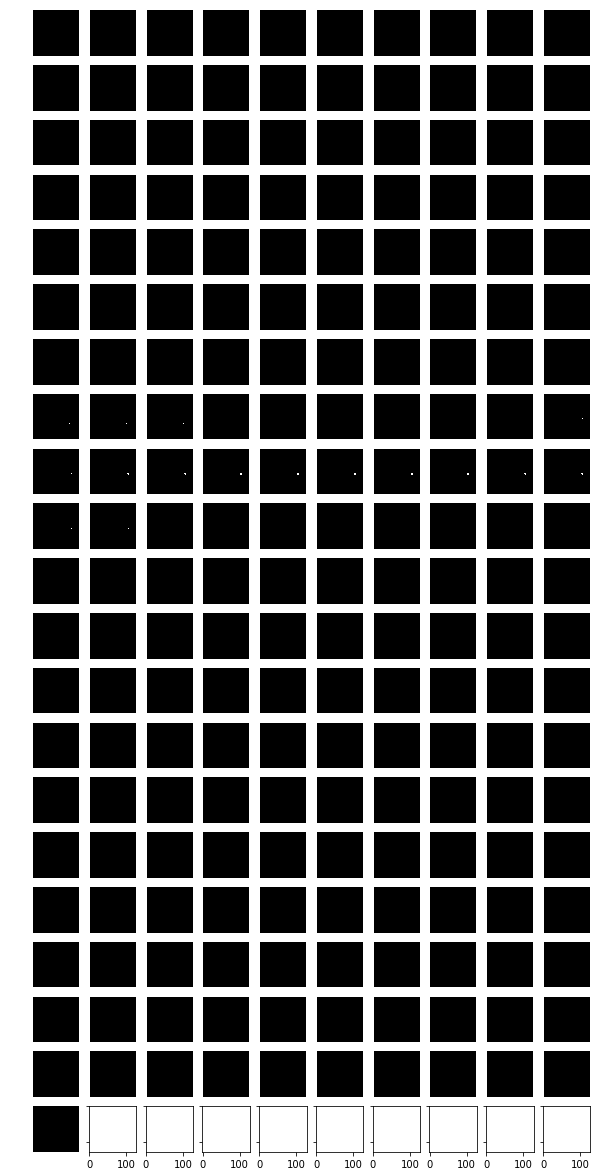

In [10]:
visualize(masks)


all the patients have different number of scans<br>
it is necessary to bring them to same number of layers<br>
[source for this averaging](https://www.kaggle.com/sentdex/first-pass-through-data-w-3d-convnet)

In [11]:
import math
def avgslides(arr, HM_SLICES):
    slices = arr
    new_slices = []
    def chunks(l, n):
        for i in range(0, len(l), n):
            yield l[i:i + n]
    def mean(l):
        return sum(l) / len(l)
    chunk_sizes = math.ceil(len(slices) / HM_SLICES)
    for slice_chunk in chunks(slices, chunk_sizes):
        slice_chunk = list(map(mean, zip(*slice_chunk)))
        new_slices.append(slice_chunk)
    if len(new_slices) == HM_SLICES-1:
        new_slices.append(new_slices[-1])

    if len(new_slices) == HM_SLICES-2:
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])

    if len(new_slices) == HM_SLICES+2:
        new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
        del new_slices[HM_SLICES]
        new_slices[HM_SLICES-1] = new_val

    if len(new_slices) == HM_SLICES+1:
        new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
        del new_slices[HM_SLICES]
        new_slices[HM_SLICES-1] = new_val     
    print(len(slices), len(new_slices))
    return new_slices

test the average function

201 20


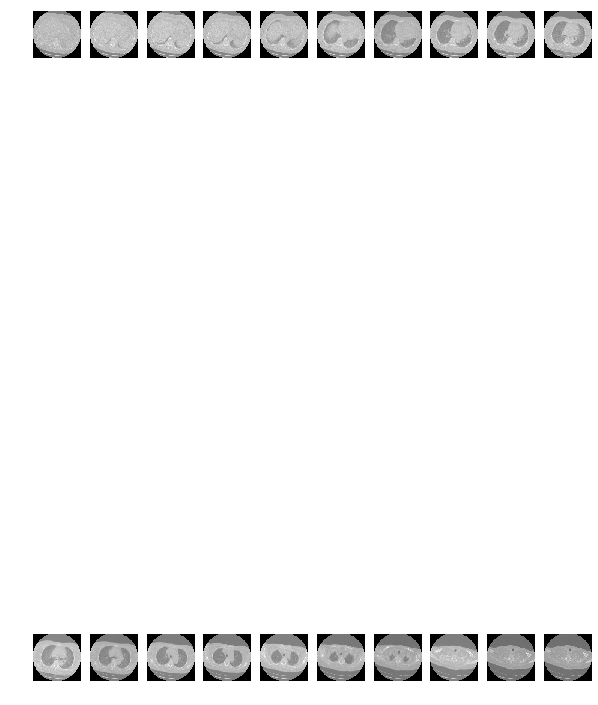

In [12]:
averaged_slides = avgslides(slides, 20)
visualize(averaged_slides, 2)

201 5


IndexError: too many indices for array

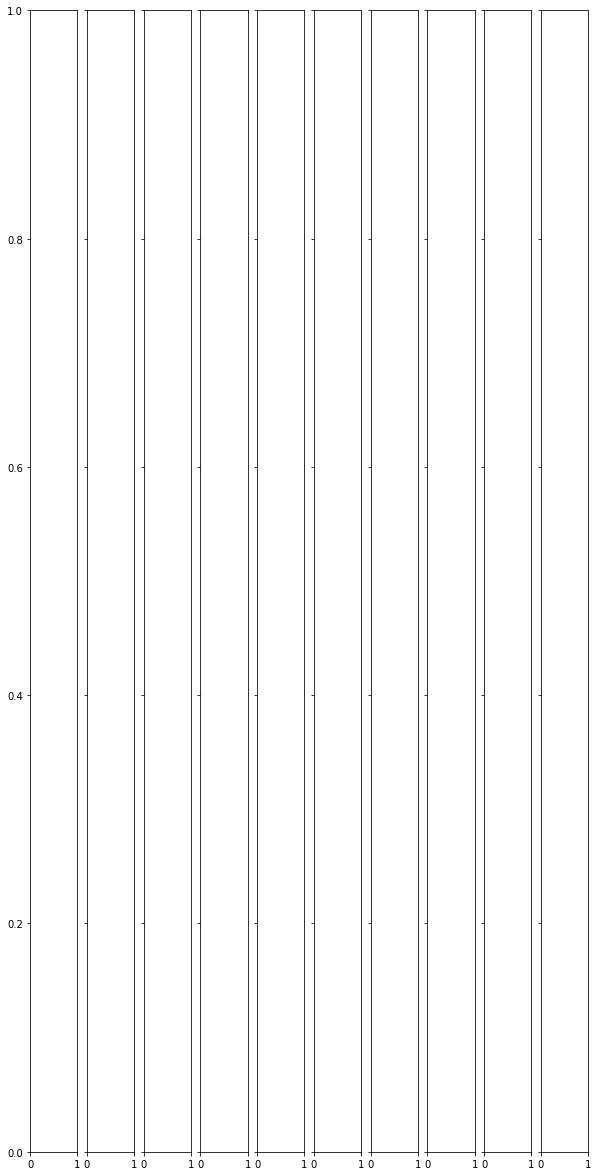

In [13]:
averaged_slides = avgslides(masks, 5)
visualize(averaged_slides, 1)

In [14]:
basepath = basepath +  "endimension-technology-test/sample_dataset_for_testing/fullsampledata/"
def load_data():
    X = []
    Y = []
    for i in os.listdir(basepath):
        pa = basepath +i +'/'+ os.listdir(basepath + i )[0] + '/'
        slide_ , mask_= load_scan(pa)
        print(slide_.shape, mask_.shape)
        X.append(np.moveaxis(avgslides(slide_, 20 ), 0, 2))
        Y.append(np.moveaxis(avgslides(mask_, 20), 0, 2))
    return (np.stack(X), np.stack(Y))
        

In [15]:
X, Y = load_data()
print(X.shape, Y.shape)

(332, 128, 128) (332, 128, 128)
332 20
332 20
(302, 128, 128) (302, 128, 128)
302 20
302 20
(336, 128, 128) (336, 128, 128)
336 20
336 20
(201, 128, 128) (201, 128, 128)
201 20
201 20
(338, 128, 128) (338, 128, 128)
338 20
338 20
(298, 128, 128) (298, 128, 128)
298 20
298 20
(336, 128, 128) (336, 128, 128)
336 20
336 20
(351, 128, 128) (351, 128, 128)
351 20
351 20
(310, 128, 128) (310, 128, 128)
310 20
310 20
(332, 128, 128) (332, 128, 128)
332 20
332 20
(10, 128, 128, 20) (10, 128, 128, 20)


In [16]:
width = IMG_WIDTH
height = IMG_HEIGHT
channel = 20

importing libraries for neural network modelling and training

In [17]:
import os
import sys
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import tensorflow as tf

Using TensorFlow backend.


defining metrics

I had learned these metrics for one of my 2d image segmentation classes while doing their course

In [18]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

smooth = 1.
# Dice Coefficient to work with Tensorflow
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

# Dice Coefficient to work outside Tensorflow
def dice_coef_2(y_true, y_pred):
    side = len(y_true[0])
    y_true_f = y_true.reshape(side*side)
    y_pred_f = y_pred.reshape(side*side)
    intersection = sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (sum(y_true_f) + sum(y_pred_f) + smooth)

defining UNET

In [19]:
def unet():
    inputs = Input((height, width, channel))
    s = Lambda(lambda x: x / 255) (inputs)

    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(channel, (1, 1), activation='sigmoid') (c9)
    return(inputs, outputs)

compile the model

In [20]:
inputs, outputs = unet()
model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss=dice_coef_loss, metrics=[dice_coef])
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 20) 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 20) 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2896        lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128, 128, 16) 0           conv2d_1[0][0]                   
____________________________________________________________________________________________

training the network

In [21]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('modelcheck.h5', verbose=1, save_best_only=True)
results = model.fit(X[:7], Y[:7], validation_data=(X[7:9], Y[7:9]), batch_size=16, epochs=200, 
                    callbacks=[earlystopper, checkpointer])

Train on 7 samples, validate on 2 samples
Epoch 1/200
7/7 [==============================] - 3s 397ms/step - loss: -0.0072 - dice_coef: 0.0072 - val_loss: -0.0011 - val_dice_coef: 0.0011

Epoch 00001: val_loss improved from inf to -0.00111, saving model to modelcheck.h5
Epoch 2/200
7/7 [==============================] - 1s 140ms/step - loss: -0.0108 - dice_coef: 0.0108 - val_loss: -0.0012 - val_dice_coef: 0.0012

Epoch 00002: val_loss improved from -0.00111 to -0.00121, saving model to modelcheck.h5
Epoch 3/200
7/7 [==============================] - 1s 141ms/step - loss: -0.0125 - dice_coef: 0.0125 - val_loss: -0.0013 - val_dice_coef: 0.0013

Epoch 00003: val_loss improved from -0.00121 to -0.00133, saving model to modelcheck.h5
Epoch 4/200
7/7 [==============================] - 1s 143ms/step - loss: -0.0138 - dice_coef: 0.0138 - val_loss: -0.0013 - val_dice_coef: 0.0013

Epoch 00004: val_loss improved from -0.00133 to -0.00133, saving model to modelcheck.h5
Epoch 5/200
7/7 [==========

evaluation

In [22]:
model.evaluate(X[9:], Y[9:])

1/1 [==============================] - 0s 40ms/step


[-0.0001516808697488159, 0.0001516808697488159]

predictions

In [23]:
Y_pred = model.predict(X[9:])

In [24]:
Y_pred.shape

(1, 128, 128, 20)

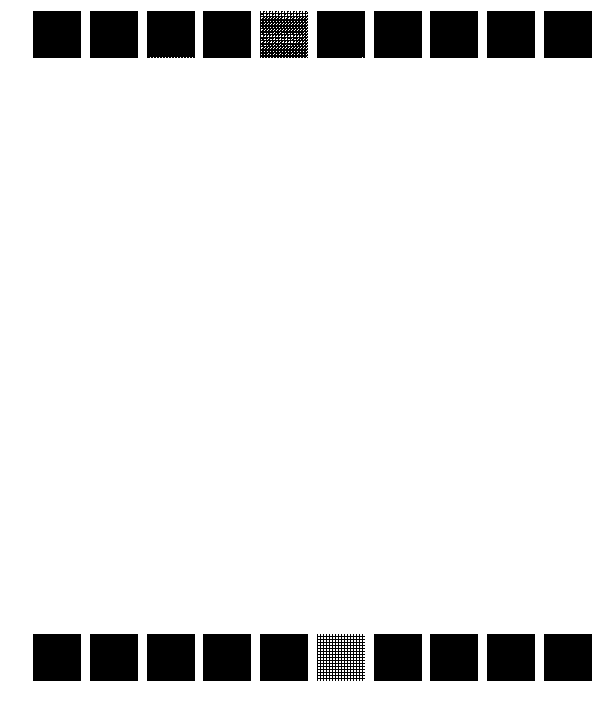

In [25]:
# visualize(Y_pred[0])
visualize(np.moveaxis(Y_pred[0], 2, 0), 2)

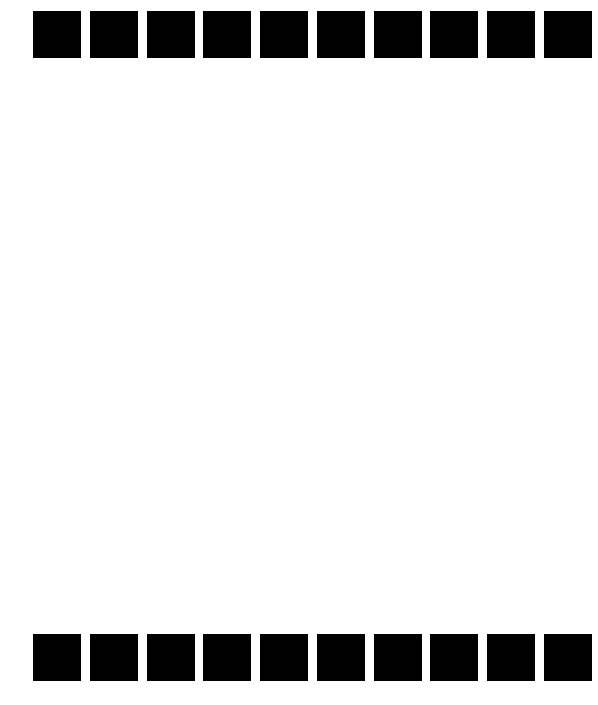

In [26]:
visualize(np.moveaxis(Y[9], 2, 0), 2)

In [27]:
!touch requirements.txt
!pip freeze -r requirements.txt

## The following requirements were added by pip freeze:
absl-py==0.9.0
affine==2.3.0
alabaster==0.7.12
albumentations==0.4.3
alembic==1.4.0
allennlp==0.9.0
altair==4.0.1
anaconda-client==1.7.2
anaconda-navigator==1.9.7
anaconda-project==0.8.3
annoy==1.16.3
appdirs==1.4.3
arrow==0.15.5
arviz==0.6.1
asn1crypto==1.3.0
astor==0.8.1
astroid==2.3.3
astropy==3.2.3
atomicwrites==1.3.0
attrs==19.3.0
audioread==2.1.8
Babel==2.8.0
backcall==0.1.0
backports.functools-lru-cache==1.6.1
backports.os==0.1.1
backports.shutil-get-terminal-size==1.0.0
backports.tempfile==1.0
backports.weakref==1.0.post1
Baker==1.3
basemap==1.2.0
bayesian-optimization==1.0.2
bayespy==0.5.19
bcolz==1.2.1
beautifulsoup4==4.8.2
biopython==1.76
bitarray==1.2.1
bkcharts==0.2
bleach==3.1.0
blis==0.4.1
bokeh==1.4.0
Boruta==0.3
boto==2.49.0
boto3==1.11.15
botocore==1.14.15
Bottleneck==1.3.1
-e git+https://github.com/SohierDane/BigQuery_Helper@8615a7f6c1663e7f2d48aa2b32c2dbcb600a440f#egg=bq_helper
bqplot==0.12.3
branca==0.3.1
brew